In [107]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms.v2 as tfs
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image


In [108]:
class MyDatasets(data.Dataset):
    def __init__(self, path, train=True, transform=None):
        self.path = os.path.join(path, "train" if train else "test")
        self.transform = transform

        with open(os.path.join(path, "format.json"), "r") as fp:
            self.format = json.load(fp)

        self.length = 0
        self.files = []
        self.targets = torch.eye(10) # единичная матрица

        for _dir, _target in self.format.items():
            path = os.path.join(self.path, _dir)
            list_files = os.listdir(path)
            self.length += len(list_files)
            self.files.extend(map(lambda _x: (os.path.join(path, _x), _target), list_files))


    def __getitem__(self, item):
        path_file, target = self.files[item]
        tensor_target = self.targets[target] # из единичной матрицы нужная строка
        img = Image.open(path_file)

        if self.transform:
            img = self.transform(img).ravel().float() / 255.0 # Нормализация

        return img, tensor_target 


    def __len__(self):
        return self.length


In [109]:
class MLP(nn.Module):
    def __init__(self, input_dim, num_hidden, output_dim):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, num_hidden)
        self.layer2 = nn.Linear(num_hidden, output_dim)


    def forward(self, x):
        x = self.layer1(x)
        x = nn.functional.relu(x)
        x = self.layer2(x)
        return x
    

In [110]:
train_dataset = MyDatasets('dataset', transform=tfs.ToImage())
test_dataset = MyDatasets('dataset', train=False, transform=tfs.ToImage())

train_data = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_data = data.DataLoader(test_dataset, batch_size=500, shuffle=True)

In [111]:
model = MLP(28 * 28, 32, 10)

In [112]:
optimizer = optim.Adam(params=model.parameters(), lr=0.01)
loss_function = nn.CrossEntropyLoss()

epochs = 2
model.train()

for _e in range(epochs):
    loss_mean = 0
    lm_count = 0

    train_tqdm = tqdm(train_data, leave=True)
    for x_train, y_train in train_tqdm:
        predict = model(x_train)
        loss = loss_function(predict, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lm_count += 1
        loss_mean = 1/lm_count * loss.item() + (1 - 1/lm_count) * loss_mean
        train_tqdm.set_description(f"Epoch [{_e+1}/{epochs}], loss_mean={loss_mean:.3f}")



  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [2/2], loss_mean=0.180: 100%|██████████| 1875/1875 [00:33<00:00, 56.09it/s]


In [113]:
model.eval()
Q = 0

test_tqdm = tqdm(test_data, leave=True)
for x_test, y_test in test_tqdm:
    with torch.no_grad():
        p = model(x_test)
        p = torch.argmax(p, dim=1)
        y = torch.argmax(y_test, dim=1)
        Q += torch.sum(p == y).item()

Q /= len(test_dataset)
print(Q)

100%|██████████| 20/20 [00:04<00:00,  4.62it/s]

0.9504


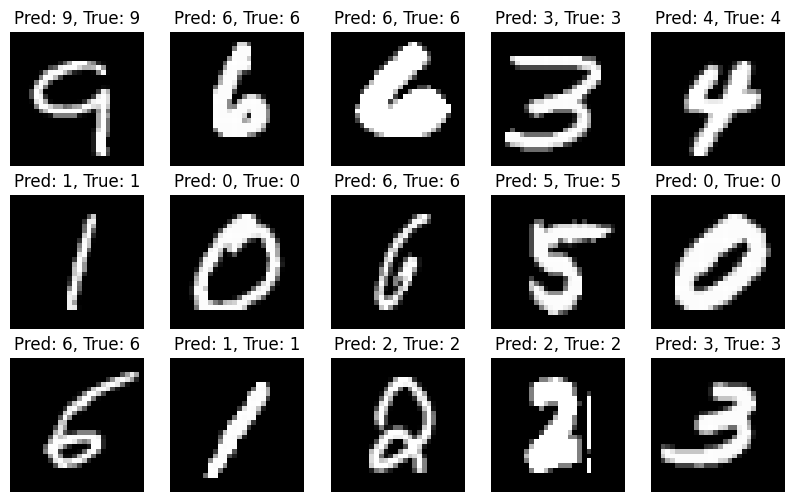

In [114]:
data_iter = iter(test_data)
images, labels = next(data_iter)
outputs = model(images)
predictions = outputs.argmax(1)

fig, axes = plt.subplots(3, 5, figsize=(10, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].resize(28, 28).cpu().squeeze(), cmap='gray')
    ax.set_title(f'Pred: {predictions[i].item()}, True: {labels[i].argmax().item()}')
    ax.axis('off')

plt.show()